In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

sys.path.append("../../..")
from batchflow import *
from batchflow.opensets import MNIST
from batchflow.eager_models import EagerTorch

# Setup

In [2]:
mnist = MNIST(batch_class=ImagesBatch)

if __name__ == '__main__':
    MICROBATCH = None
    DEVICE = None

print('\nMicrobatching is: {}'.format(MICROBATCH))
print('\nDevice is: {}'.format(DEVICE))    


Microbatching is: None

Device is: None


In [3]:
IMAGE_SHAPE = (1, 28, 28)

def get_classification_config(model_class, config):
    default_config = {
#         'inputs/images/shape': IMAGE_SHAPE,
#         'inputs/labels/classes': 10,
#         'initial_block/inputs': 'images',
        'loss': 'ce',
        'microbatch': MICROBATCH,
        'device': DEVICE,
    }

    pipeline_config = {
        'model': model_class,
        'model_config': {**default_config, **config},
        'feed_dict': {'images': B('images'),
                      'labels': B('labels')},
    }
    return pipeline_config

def get_segmentation_config(model_class, config):
    default_config = {
        'inputs/images/shape': IMAGE_SHAPE,
        'inputs/masks/shape': IMAGE_SHAPE,
        'initial_block/inputs': 'images',
        'body/decoder/blocks/combine_op': 'concat', # for some reason `concat` is not working from within pytest 
        'loss': 'mse',
        'microbatch': MICROBATCH,
        'device': DEVICE,
    }
    
    pipeline_config = {
        'model': model_class,
        'model_config': {**default_config, **config},
        'feed_dict': {'images': B('images'),
                      'masks': B('images')},
    }
    return pipeline_config

In [4]:
def get_pipeline(pipeline_config):
    """ Pipeline config must contain 'model', 'model_config', 'feed_dict' keys. """
    vals = pipeline_config['feed_dict'].values()

    pipeline = (Pipeline(config=pipeline_config)
                .init_variable('loss_history', [])
#                 .multiply(multiplier=1/255., preserve_type=False)
                .to_array(channels='first', dtype='float32')
                .init_model('dynamic', C('model'),
                            'MODEL', config=C('model_config'))
                .train_model('MODEL', *vals,
                             fetches='loss',
                             save_to=V('loss_history', mode='a'))
                )
    return pipeline

In [5]:
def run(task, model_class, config, description, batch_size=16, n_iters=10):
    if task.startswith('c'):
        pipeline_config = get_classification_config(model_class, config)
    elif task.startswith('s'):
        pipeline_config = get_segmentation_config(model_class, config)
        
    train_pipeline = get_pipeline(pipeline_config) << mnist.train
    _ = train_pipeline.run(batch_size, n_iters=n_iters, bar=True,
                           bar_desc=W(V('loss_history')[-1].format('Loss is {:7.7}')))
    
    print('{} {} is done'.format(task, description))
    return train_pipeline

# Classification

In [6]:
default_config = {
    'inputs/images/shape': IMAGE_SHAPE,
    'inputs/labels/classes': 10,
    'initial_block/inputs': 'images',
    'initial_block': {'layout': 'fafaf', 'units': [128, 256, 10]},
    'loss': 'ce',
    'microbatch': MICROBATCH,
    'device': DEVICE,
}

model = EagerTorch(default_config)

_BUILD IN BUILD
fafaf


In [7]:
model.model

Sequential(
  (0): ConvBlock(
    (block): Sequential(
      (0): Dense(
        (linear): Linear(in_features=784, out_features=128, bias=True)
      )
      (1): Activation(
        (activation): ReLU(inplace=True)
      )
      (2): Dense(
        (linear): Linear(in_features=128, out_features=256, bias=True)
      )
      (3): Activation(
        (activation): ReLU(inplace=True)
      )
      (4): Dense(
        (linear): Linear(in_features=256, out_features=10, bias=True)
      )
    )
  )
)

In [8]:
class Dense(nn.Module):
    def __init__(self, units=None, out_features=None, bias=True, inputs=None):
        super().__init__()

        in_units = np.prod(inputs.shape[1:])
        units = units or out_features
        self.linear = nn.Linear(in_units, units, bias)

    def forward(self, x):
        """ Make forward pass """
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        return self.linear(x)

In [9]:
config = {
    'initial_block': {'layout': 'fafaf',
                      'units': [512, 256, 10]},
    'body': {'module': Dense, 'module_kwargs': {'units': 10}},
#     'body': {'layout': 'fa'*2,
#              'units': [256, 10]},
#     'head': {'layout': 'faf',
#              'units': [600,10]},
}

ppl = run('classification', EagerTorch, config, 'simple fc', n_iters=200, batch_size=64)

Loss is  11.405:   2%|▏         | 3/200 [00:00<00:08, 21.99it/s] 

_BUILD IN TRAIN
fafaf


Loss is 0.3203713: 100%|██████████| 200/200 [00:05<00:00, 38.26it/s]

classification simple fc is done


In [10]:
test_pipeline = (mnist.test.p
                .import_model('MODEL', ppl)
                .init_variable('predictions') 
                .init_variable('metrics', init_on_each_run=None) 
                .to_array(channels='first', dtype='float32')
                .predict_model('MODEL', B.images,
                               fetches='predictions', save_to=V('predictions'))
                .gather_metrics('class', targets=B.labels, predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics', mode='w'))
                .run(64, shuffle=True, n_epochs=1, drop_last=False, bar=True)
)

100%|██████████| 157/157 [00:01<00:00, 85.57it/s]


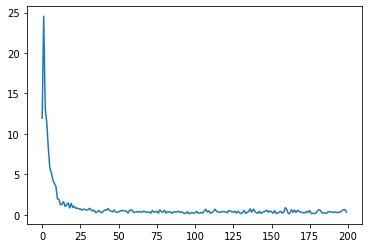

In [11]:
plt.plot(ppl.v('loss_history'))

In [12]:
metrics = test_pipeline.get_variable('metrics')
metrics.evaluate('accuracy')

1.0

In [13]:
ppl.get_model_by_name('MODEL').model

Sequential(
  (0): ConvBlock(
    (block): Sequential(
      (0): Dense(
        (linear): Linear(in_features=784, out_features=512, bias=True)
      )
      (1): Activation(
        (activation): ReLU(inplace=True)
      )
      (2): Dense(
        (linear): Linear(in_features=512, out_features=256, bias=True)
      )
      (3): Activation(
        (activation): ReLU(inplace=True)
      )
      (4): Dense(
        (linear): Linear(in_features=256, out_features=10, bias=True)
      )
    )
  )
  (1): Dense(
    (linear): Linear(in_features=10, out_features=10, bias=True)
  )
)

# Segmentation

In [14]:
# config = {
#     'initial_block/filters': 4,
#     'body/encoder': {'num_stages': 3},
# }

# ppl = run('segmentation', EagerTorch, config, 'unet')